In [1]:
import pickle
import tensorflow as tf
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn import metrics
from sklearn.utils import resample
import os
import traceback
from collections import deque
from __future__ import division

import seaborn as sns
sns.set()

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [10]:
#path = '/scratch/users/rmth/tf_logs/c-shhs_cluster_revised-shallow_cv/'
#path = '/scratch/users/rmth/tf_logs/c-shhs-multimodal_cluster_revised-shallow_cv/'
#path = '/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/'
path = '/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow-noise_cv/'
fold_folders = [ e for e in os.listdir(path) if os.path.isdir(os.path.join(path, e)) ]
print(fold_folders)

['cv3', 'cv4', 'cv6', 'cv2', 'cv5', 'cv7', 'cv8', 'cv9', 'cv1']


In [11]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p,:]

def gen_data(exp, con, batch_size, max_length, n_features):
    n = batch_size // 2
    x = np.zeros(shape = (batch_size, max_length, n_features))
    y = np.zeros(shape = (batch_size, 2))
    shuffle(exp)
    shuffle(con)
    for i in range(n):
        e = exp[i]
        #print('e.shape1: {}'.format(e.shape[0]))
        c = con[i]
        #print('c.shape1: {}'.format(c.shape[0]))
        x[i, 0:c.shape[0], 0:n_features] = c
        y[i,0] = 1

        x[i+n, 0:e.shape[0], 0:n_features] = e
        y[i+n,1] = 1
    return unison_shuffled_copies(x,y)

In [20]:
hidden_size = 16
n_dense = 16
batch_size_train = 8
regularization = 0.1
dense_regularization = 0.1
rnn_dropout_prob = 0.4
lr = 1e-3 #was 1e-5
#training_steps = 300 #1000
display_step = 20
buffer_length = 5
final_dropout = 0.05
#max_step = 10
max_step = 3000 #3000
tol = 1e-3
patience = 5

#Final: AUC=0.84693877551, acc.=0.785714268684

In [25]:
hidden_size = 128
n_dense = 1048
batch_size_train = 8
regularization = 0.1
dense_regularization = 0.1
rnn_dropout_prob = 0.4
lr = 1e-4
#training_steps = 300 #1000
display_step = 20
buffer_length = 3
final_dropout = 0.02
#max_step = 10
max_step = 3000 #3000
tol = 1e-2
patience = 2

#Final: AUC=0.510204081633, acc.=0.571428596973

In [13]:
hidden_size = 128
n_dense = 256
batch_size_train = 8
regularization = 0.1
dense_regularization = 0.1
rnn_dropout_prob = 0.4
lr = 1e-4
#training_steps = 300 #1000
display_step = 20
buffer_length = 3
final_dropout = 0.05
#max_step = 10
max_step = 3000 #3000
tol = 1e-2
patience = 2

#Test accuracy: 0.672 (CI: [0.6-0.746] +/- 0.109)
#Test sens: 0.727 (CI: [0.653-0.813] +/- 0.116)
#Test spec: 0.619 (CI: [0.475-0.759] +/- 0.196)


In [26]:
rocfigs, rocs = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
f1figs, f1s = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
senses_aggr = []
speces_aggr = []
accs_aggr = []

senses_aggr_easy = []
speces_aggr_easy = []
accs_aggr_easy = []
for fold_counter, fold in enumerate(fold_folders):
    #if fold != 'cv6':
    #    continue
    try:
        print('Training {} ({} of {})'.format(fold, fold_counter+1, len(fold_folders)))
        fold_number = int(fold[2])
        with open(path + fold + '/eval/' + 'features.pkl', 'rb') as f:
            train_group, train_feat, val_group, val_feat, test_group, test_feat, matched_feat, matched_group = pickle.load(f)#, encoding='latin1')
            
        matched_ids = [e for e in matched_group.keys()]

        train_label_exp = []
        train_feat_exp = []
        train_label_con = []
        train_feat_con = []
        for k, v in train_group.items():
            if v:
                train_label_exp.append(v)
                train_feat_exp.append(train_feat[k])
            else:
                train_label_con.append(v)
                train_feat_con.append(train_feat[k])

        val_label = []
        val_ft = []
        for k,v in val_group.items():
            if v:
                val_label.append(v)
                val_ft.append(val_feat[k])
        n_exp_val = len(val_label)

        test_label = []
        test_ft = []
        for k,v in test_group.items():
            if v:
                test_label.append(v)
                test_ft.append(test_feat[k])
        n_exp_test = len(test_label)

        matched_label_val = []
        matched_feat_val = []
        shuffle(matched_ids)
        for k, v in matched_group.items():
            if k in matched_ids[:n_exp_val]:
                matched_label_val.append(v)
                matched_feat_val.append(matched_feat[k])

        matched_label_test = []
        matched_feat_test = []
        for k, v in matched_group.items():
            if k in matched_ids[n_exp_val:n_exp_val+n_exp_test]:
                matched_label_test.append(v)
                matched_feat_test.append(matched_feat[k])

        matched_label_train = []
        matched_feat_train = []
        for k, v in matched_group.items():
            if k in matched_ids[n_exp_val+n_exp_test:]:
                matched_label_train.append(v)
                matched_feat_train.append(matched_feat[k])
        _,n_features = train_feat_exp[0].shape
        max_length = np.max([len(e) for e in train_feat_exp + train_feat_con + val_ft + matched_feat_train + matched_feat_test])

        x_test = np.zeros(shape=(n_exp_test*2, max_length, n_features))
        y_test = np.zeros(shape=(n_exp_test*2, 2))
        y_test[0:n_exp_test,0] = 1
        y_test[n_exp_test:,1] = 1
        for i,e in enumerate(matched_feat_test+test_ft):
            x_test[i, 0:len(e), :] = e


        x_val = np.zeros(shape=(n_exp_val*2, max_length, n_features))
        y_val = np.zeros(shape=(n_exp_val*2, 2))
        y_val[0:n_exp_val,0] = 1
        y_val[n_exp_val:,1] = 1
        for i,e in enumerate(matched_feat_val+val_ft):
            x_val[i, 0:len(e), :] = e
            
        
        tf.reset_default_graph()
        x = tf.placeholder(shape=(None, max_length, n_features), dtype=tf.float32)
        y = tf.placeholder(shape=(None, 2), dtype=tf.float32)
        prob = tf.placeholder_with_default(1.0, shape=())
        batch_size = tf.shape(x)[0]

        #lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)
        #lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)

        #lstm_fw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_size)
        #lstm_bw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_size)
        
        #lstm_fw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        #lstm_bw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        
        lstm_fw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(hidden_size)
        lstm_bw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(hidden_size)

        lstm_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm_fw_cell, output_keep_prob=prob)
        lstm_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm_bw_cell, output_keep_prob=prob)

        #lstm_fw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        #lstm_bw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)

        outputs, states = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell, inputs=x, dtype=tf.float32)
        
        #print('outputs.shape: {}'.format(outputs[0].shape))
        output_rnn = tf.concat(outputs, axis=2)
        #print('output_rnn.shape: {}'.format(output_rnn.shape))

        #print('states.shape: {}'.format(states[0].shape))
        #states_flat = [tf.contrib.layers.flatten(e) for e in states]
        #print('states_flat.shape: {}'.format(states_flat[0].shape))
        #states_flat_concat = tf.concat(states_flat, axis=2)
        #print('states_flat.shape: {}'.format(states_flat.shape))
        
        logit_input = tf.reshape(output_rnn, [batch_size, hidden_size*2*max_length])
        dense = tf.layers.dense(inputs=logit_input,
                                 units=n_dense,
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=dense_regularization),
                                 activation=tf.nn.selu
                                 )
        do = tf.nn.dropout(dense,
                        keep_prob=final_dropout)

        logit = tf.layers.dense(inputs=do,
                                 units=2)

        tv = tf.trainable_variables()
        regularization_cost = regularization * tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y)) + regularization_cost

        #optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
        optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)
        pred = tf.argmax(logit,1)
        correct_pred = tf.equal(pred, tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        softmax = tf.nn.softmax(logit)
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)
            #for step in range(1, training_steps + 1):
            step = 0
            while True:
                step += 1
                #print(step)
                #batch_x, batch_y = gen_data(val_ft, matched_feat_train, batch_size_train, max_length, n_features)
                #batch_x, batch_y = gen_data(train_feat_exp, train_feat_con, batch_size_train, max_length, n_features)
                batch_x, batch_y = gen_data(train_feat_exp, matched_feat_train, batch_size_train, max_length, n_features)
                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, prob: rnn_dropout_prob})
                if step % display_step == 0 or step == 1:
                    acc, loss = sess.run([accuracy, cost], feed_dict={x: batch_x, y: batch_y})
                    acc_val, loss_val = sess.run([accuracy, cost], feed_dict = {x: x_val, y: y_val, prob: 1.0})
                    if step == 1:
                        smoothed_val_losses = deque(np.ones(buffer_length)*loss_val)
                    else:
                        mean1 = np.mean(smoothed_val_losses)
                        smoothed_val_losses.popleft()
                        smoothed_val_losses.append(loss_val)
                        mean2 = np.mean(smoothed_val_losses)
                        diff = mean1-mean2
                        #print(diff)
                        #print(smoothed_val_losses)
                        #print(patience)
                    if step > 2*buffer_length*display_step:
                        if diff < tol:
                            patience -= 1
                        elif patience < 3:
                            patience += 1
                        if patience == 0 or step > max_step:
                            break
                    print('step: {}, train loss: {:.2f}, accuracy: {:.2f}, val loss: {:.2f}, val accuracy: {:.2f}'.format(step, loss, acc, loss_val, acc_val))
            #for step in range(10):
            #    batch_x, batch_y = gen_data(train_prob_exp, train_prob_con, batch_size_train, max_length)
            #    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, prob: 0.1})

            x_test_easy, y_test_easy = gen_data(train_feat_exp, train_feat_con, batch_size_train, max_length, n_features)
            acc_val, softmax_val = sess.run([accuracy, softmax], feed_dict = {x: x_val, y: y_val, prob: 1.0})
            acc_test_easy, softmax_test_easy = sess.run([accuracy, softmax], feed_dict={x: x_test_easy, y: y_test_easy, prob: 1.0})
            acc_test, softmax_test = sess.run([accuracy, softmax], feed_dict = {x: x_test, y: y_test, prob: 1.0})

        fpr_val, tpr_val, thress_val = roc_curve(np.argmax(y_val,axis=1), softmax_val[:,1])
        fpr_test_easy, tpr_test_easy, thress_test_easy = roc_curve(np.argmax(y_test_easy,axis=1), softmax_test_easy[:,1])
        fpr_test, tpr_test, thress_test = roc_curve(np.argmax(y_test,axis=1), softmax_test[:,1])

        
        auc_val = auc(fpr_val, tpr_val)
        auc_test = auc(fpr_test, tpr_test)
        auc_test_easy = auc(fpr_test_easy, tpr_test_easy)

        print('Final: AUC={}, acc.={}'.format(auc_test, acc_test))
        
        f1s_original = []
        for t in thress_val:
            f1s_original.append(f1_score(y_true=np.argmax(y_val,axis=1), y_pred=np.asarray(softmax_val[:,1] > t, dtype=np.float32)))

        n_bootstraps = 300
        thress_val = np.arange(0,1,0.05)
        f1s_bootstraps = np.zeros((len(thress_val), n_bootstraps))
        accs_bootstraps = np.zeros((len(thress_val), n_bootstraps))
        true_val = np.argmax(y_val,axis=1)
        est_val = softmax_val[:,1]
        pairs = np.zeros((len(true_val), 2))
        pairs[:,0] = true_val
        pairs[:,1] = est_val
        for j in range(n_bootstraps):
            #if j % 100 == 0:
            #    print(j/n_bootstraps*100)
            pairs_boot = resample(pairs, n_samples = 20, replace=True)
            true_val_boot = pairs_boot[:,0]
            est_val_boot = pairs_boot[:,1]
            for i, t in enumerate(thress_val):
                tn, fp, fn, tp = metrics.confusion_matrix(true_val_boot, np.asarray(est_val_boot > t, dtype=np.float32)).ravel()
                tpr = tp/(tp+fn)
                fpr = fp/(tn+fp)
                speci = 1-fpr
                f1s_bootstraps[i, j] = 2 * (tpr * speci) / (tpr + speci + np.spacing(0))
                #f1s_bootstraps[i, j] = f1_score(y_true=true_val_boot, y_pred=np.asarray(est_val_boot > t, dtype=np.float32))
                accs_bootstraps[i, j] = accuracy_score(y_true=true_val_boot, y_pred=np.asarray(est_val_boot > t, dtype=np.float32))

        f1s_m = np.median(f1s_bootstraps, axis=1)
        accs = np.mean(accs_bootstraps, axis=1)

        f1s_l = np.percentile(f1s_bootstraps, q=5, axis=1)
        f1s_u = np.percentile(f1s_bootstraps, q=95, axis=1)
        index = f1s_m/(f1s_u - f1s_l + np.spacing(0))
        
        
        '''
        fig, ax = plt.subplots(ncols=3)
        ax[0].plot(thress_val, f1s_m)
        ax[0].plot(thress_val, f1s_l,'--')
        ax[0].plot(thress_val, f1s_u,'--')
        ax[1].plot(thress_val, index)
        ax[2].plot(thress_val, f1s_original)
        for i in range(3):
            ax[i].set_xlim([0, 1])
        ax[0].set_ylim([0,1])
        ax[2].set_ylim([0,1])
        '''

        best_t_idx = np.nanargmax(index)
        #best_t_idx = np.nanargmax(f1s_m)
        best_t = thress_val[best_t_idx]

        test_accuracy_easy = accuracy_score(y_true=np.argmax(y_test_easy, axis=1),
                                       y_pred=np.asarray(softmax_test_easy[:, 1] > best_t, dtype=np.float32))
        tn, fp, fn, tp = metrics.confusion_matrix(np.argmax(y_test_easy, axis=1), softmax_test_easy[:, 1] > best_t).ravel()
        test_sensitivity_easy = tp / (tp + fn)
        test_specificity_easy = 1 - (fp / (tn + fp))

        accs_aggr_easy.append(test_accuracy_easy)
        senses_aggr_easy.append(test_sensitivity_easy)
        speces_aggr_easy.append(test_specificity_easy)

        test_accuracy = accuracy_score(y_true=np.argmax(y_test,axis=1), y_pred=np.asarray(softmax_test[:,1] > best_t, dtype=np.float32))
        tn, fp, fn, tp = metrics.confusion_matrix(np.argmax(y_test, axis=1), softmax_test[:, 1] > best_t).ravel()
        test_sensitivity = tp / (tp + fn)
        test_specificity = 1 - (fp / (tn+fp))

        accs_aggr.append(test_accuracy)
        senses_aggr.append(test_sensitivity)
        speces_aggr.append(test_specificity)

        lw = 2
        a = (fold_number - 1) // 3
        b = (fold_number - 1) % 3


        rocs[a,b].plot(fpr_test_easy, tpr_test_easy, '--', color='gray',
                   lw=lw,
                   label='Unmatched, AUC: {:.2f}'.format(auc_test_easy))
        rocs[a,b].plot(fpr_test, tpr_test, color='black',
                   lw=lw,
                   label='Matched, AUC: {:.2f}, acc.: {:.2f}, sens.: {:.2f}, spec.: {:.2f}'.format(auc_test,
                                                                                                test_accuracy,
                                                                                                test_sensitivity,
                                                                                                test_specificity, ))
        rocs[a,b].plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
        rocs[a,b].set_title('Cross-validation fold {}'.format(fold_number))
        rocs[a,b].legend(loc="lower right")
        rocs[a,b].set_xlim([0.0, 1.0])
        rocs[a,b].set_ylim([0.0, 1.0])
        rocs[a,b].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        rocs[a,b].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        if a == 2: 
            rocs[a,b].set_xlabel('False Positive Rate')
        else:
            rocs[a, b].set_xticklabels(['', '', '', '', '', ''])
        if b == 0:
            rocs[a,b].set_ylabel('True Positive Rate')
        else:
            rocs[a, b].set_yticklabels(['', '', '', '', '', ''])


        f1s[a,b].plot(thress_val, f1s_m, color='black')
        f1s[a, b].plot(thress_val[best_t_idx], f1s_m[best_t_idx], 'or')
        f1s[a, b].set_title('F1-scores (validation, bootstrapped): {}'.format(fold_number))
        f1s[a, b].set_ylim([0.0, 1.0])
        rocs[a,b].set_xlim([0.0, 1.0])
        f1s[a, b].set_xlabel('Threshold')
        f1s[a, b].set_ylabel('f1-score')

    except Exception as e:
        print('Something went wrong with: {}'.format(fold_number))
        print(e)
        print(traceback.format_exc())
print('Done.')


Training cv3 (1 of 9)
step: 1, train loss: 205.25, accuracy: 0.38, val loss: 205.11, val accuracy: 0.56
step: 20, train loss: 205.28, accuracy: 0.38, val loss: 205.03, val accuracy: 0.56
step: 40, train loss: 204.65, accuracy: 0.62, val loss: 204.48, val accuracy: 0.56
step: 60, train loss: 203.14, accuracy: 0.88, val loss: 203.47, val accuracy: 0.44
step: 80, train loss: 200.99, accuracy: 0.62, val loss: 201.05, val accuracy: 0.31
step: 100, train loss: 194.06, accuracy: 0.75, val loss: 194.78, val accuracy: 0.50
step: 120, train loss: 182.66, accuracy: 0.62, val loss: 181.37, val accuracy: 0.56
step: 140, train loss: 163.42, accuracy: 0.75, val loss: 164.41, val accuracy: 0.50
step: 160, train loss: 145.30, accuracy: 0.75, val loss: 145.42, val accuracy: 0.50
step: 180, train loss: 129.75, accuracy: 0.62, val loss: 130.07, val accuracy: 0.69
step: 200, train loss: 117.56, accuracy: 0.50, val loss: 118.38, val accuracy: 0.56
step: 220, train loss: 108.31, accuracy: 0.75, val loss: 108

step: 1980, train loss: 17.03, accuracy: 1.00, val loss: 17.85, val accuracy: 0.38
step: 2000, train loss: 16.88, accuracy: 1.00, val loss: 17.88, val accuracy: 0.50
step: 2020, train loss: 16.80, accuracy: 1.00, val loss: 17.79, val accuracy: 0.44
step: 2040, train loss: 16.69, accuracy: 1.00, val loss: 18.39, val accuracy: 0.44
step: 2060, train loss: 16.70, accuracy: 0.88, val loss: 17.97, val accuracy: 0.50
step: 2080, train loss: 16.54, accuracy: 1.00, val loss: 17.74, val accuracy: 0.44
step: 2100, train loss: 16.45, accuracy: 1.00, val loss: 17.62, val accuracy: 0.44
step: 2120, train loss: 16.33, accuracy: 1.00, val loss: 17.63, val accuracy: 0.38
step: 2140, train loss: 16.26, accuracy: 1.00, val loss: 17.45, val accuracy: 0.44
step: 2160, train loss: 16.21, accuracy: 1.00, val loss: 17.20, val accuracy: 0.38
step: 2180, train loss: 16.10, accuracy: 1.00, val loss: 17.12, val accuracy: 0.38
step: 2200, train loss: 16.04, accuracy: 1.00, val loss: 17.23, val accuracy: 0.44
step

step: 940, train loss: 24.39, accuracy: 1.00, val loss: 26.40, val accuracy: 0.56
step: 960, train loss: 24.13, accuracy: 1.00, val loss: 25.75, val accuracy: 0.62
step: 980, train loss: 23.87, accuracy: 1.00, val loss: 25.11, val accuracy: 0.56
step: 1000, train loss: 23.60, accuracy: 1.00, val loss: 24.67, val accuracy: 0.44
step: 1020, train loss: 23.32, accuracy: 1.00, val loss: 25.33, val accuracy: 0.62
step: 1040, train loss: 23.09, accuracy: 1.00, val loss: 24.05, val accuracy: 0.62
step: 1060, train loss: 22.88, accuracy: 1.00, val loss: 24.67, val accuracy: 0.56
step: 1080, train loss: 22.62, accuracy: 1.00, val loss: 24.04, val accuracy: 0.56
step: 1100, train loss: 22.44, accuracy: 1.00, val loss: 23.37, val accuracy: 0.56
step: 1120, train loss: 22.20, accuracy: 1.00, val loss: 23.15, val accuracy: 0.50
step: 1140, train loss: 21.97, accuracy: 1.00, val loss: 23.22, val accuracy: 0.62
step: 1160, train loss: 21.77, accuracy: 1.00, val loss: 23.15, val accuracy: 0.56
step: 1

step: 2920, train loss: 13.22, accuracy: 1.00, val loss: 14.50, val accuracy: 0.56
step: 2940, train loss: 13.14, accuracy: 1.00, val loss: 14.47, val accuracy: 0.50
step: 2960, train loss: 13.15, accuracy: 1.00, val loss: 14.51, val accuracy: 0.56
step: 2980, train loss: 13.02, accuracy: 1.00, val loss: 14.14, val accuracy: 0.56
step: 3000, train loss: 12.91, accuracy: 1.00, val loss: 13.92, val accuracy: 0.50
Final: AUC=0.515625, acc.=0.5625
Training cv6 (3 of 9)
step: 1, train loss: 205.93, accuracy: 0.50, val loss: 205.58, val accuracy: 0.14
step: 20, train loss: 205.22, accuracy: 0.50, val loss: 205.78, val accuracy: 0.21
step: 40, train loss: 204.58, accuracy: 0.50, val loss: 205.18, val accuracy: 0.50
step: 60, train loss: 204.60, accuracy: 0.12, val loss: 203.78, val accuracy: 0.57
step: 80, train loss: 201.36, accuracy: 0.50, val loss: 202.57, val accuracy: 0.50
step: 100, train loss: 196.43, accuracy: 0.50, val loss: 195.60, val accuracy: 0.43
step: 120, train loss: 183.11, a

step: 240, train loss: 98.25, accuracy: 0.88, val loss: 100.01, val accuracy: 0.50
step: 260, train loss: 91.95, accuracy: 0.88, val loss: 92.71, val accuracy: 0.44
step: 280, train loss: 85.44, accuracy: 0.88, val loss: 85.89, val accuracy: 0.69
step: 300, train loss: 80.41, accuracy: 0.62, val loss: 82.61, val accuracy: 0.56
step: 320, train loss: 75.40, accuracy: 0.88, val loss: 76.17, val accuracy: 0.38
step: 340, train loss: 70.72, accuracy: 1.00, val loss: 73.59, val accuracy: 0.25
step: 360, train loss: 66.50, accuracy: 1.00, val loss: 67.78, val accuracy: 0.56
step: 380, train loss: 62.68, accuracy: 1.00, val loss: 64.72, val accuracy: 0.50
step: 400, train loss: 58.86, accuracy: 1.00, val loss: 61.15, val accuracy: 0.44
step: 420, train loss: 55.51, accuracy: 1.00, val loss: 57.10, val accuracy: 0.31
step: 440, train loss: 52.33, accuracy: 1.00, val loss: 53.76, val accuracy: 0.56
step: 460, train loss: 49.14, accuracy: 1.00, val loss: 50.24, val accuracy: 0.69
step: 480, trai

step: 2240, train loss: 15.86, accuracy: 1.00, val loss: 17.11, val accuracy: 0.50
step: 2260, train loss: 15.75, accuracy: 1.00, val loss: 17.15, val accuracy: 0.50
step: 2280, train loss: 15.66, accuracy: 1.00, val loss: 17.08, val accuracy: 0.50
step: 2300, train loss: 15.60, accuracy: 1.00, val loss: 16.73, val accuracy: 0.50
step: 2320, train loss: 15.51, accuracy: 1.00, val loss: 16.74, val accuracy: 0.50
step: 2340, train loss: 15.43, accuracy: 1.00, val loss: 16.79, val accuracy: 0.44
step: 2360, train loss: 15.35, accuracy: 1.00, val loss: 16.70, val accuracy: 0.50
step: 2380, train loss: 15.27, accuracy: 1.00, val loss: 16.26, val accuracy: 0.50
step: 2400, train loss: 15.21, accuracy: 1.00, val loss: 16.74, val accuracy: 0.50
step: 2420, train loss: 15.11, accuracy: 1.00, val loss: 16.36, val accuracy: 0.56
step: 2440, train loss: 15.04, accuracy: 1.00, val loss: 16.44, val accuracy: 0.50
step: 2460, train loss: 14.96, accuracy: 1.00, val loss: 16.18, val accuracy: 0.50
step

step: 1200, train loss: 21.84, accuracy: 1.00, val loss: 23.03, val accuracy: 0.43
step: 1220, train loss: 21.60, accuracy: 1.00, val loss: 22.77, val accuracy: 0.50
step: 1240, train loss: 21.46, accuracy: 1.00, val loss: 22.83, val accuracy: 0.50
step: 1260, train loss: 21.31, accuracy: 1.00, val loss: 22.56, val accuracy: 0.43
step: 1280, train loss: 21.06, accuracy: 1.00, val loss: 22.18, val accuracy: 0.43
step: 1300, train loss: 20.94, accuracy: 1.00, val loss: 22.17, val accuracy: 0.43
step: 1320, train loss: 21.13, accuracy: 0.88, val loss: 21.79, val accuracy: 0.43
step: 1340, train loss: 20.54, accuracy: 1.00, val loss: 21.52, val accuracy: 0.43
step: 1360, train loss: 20.35, accuracy: 1.00, val loss: 21.40, val accuracy: 0.36
step: 1380, train loss: 21.17, accuracy: 0.75, val loss: 21.84, val accuracy: 0.50
step: 1400, train loss: 20.03, accuracy: 1.00, val loss: 21.06, val accuracy: 0.50
step: 1420, train loss: 19.89, accuracy: 1.00, val loss: 21.03, val accuracy: 0.50
step

step: 160, train loss: 141.65, accuracy: 0.62, val loss: 141.19, val accuracy: 0.33
step: 180, train loss: 123.16, accuracy: 0.75, val loss: 123.82, val accuracy: 0.58
step: 200, train loss: 112.88, accuracy: 0.50, val loss: 109.89, val accuracy: 0.75
step: 220, train loss: 100.28, accuracy: 0.62, val loss: 100.27, val accuracy: 0.75
step: 240, train loss: 91.70, accuracy: 0.75, val loss: 91.78, val accuracy: 0.58
step: 260, train loss: 85.86, accuracy: 0.50, val loss: 85.85, val accuracy: 0.50
step: 280, train loss: 80.20, accuracy: 0.38, val loss: 81.26, val accuracy: 0.33
step: 300, train loss: 77.44, accuracy: 0.38, val loss: 75.09, val accuracy: 0.67
step: 320, train loss: 71.82, accuracy: 0.50, val loss: 71.15, val accuracy: 0.50
step: 340, train loss: 67.93, accuracy: 0.50, val loss: 67.56, val accuracy: 0.58
step: 360, train loss: 64.34, accuracy: 0.62, val loss: 64.31, val accuracy: 0.42
step: 380, train loss: 61.68, accuracy: 0.62, val loss: 61.42, val accuracy: 0.42
step: 40

step: 2160, train loss: 16.62, accuracy: 1.00, val loss: 17.24, val accuracy: 0.50
step: 2180, train loss: 16.45, accuracy: 1.00, val loss: 17.12, val accuracy: 0.33
step: 2200, train loss: 16.42, accuracy: 1.00, val loss: 16.92, val accuracy: 0.42
step: 2220, train loss: 16.25, accuracy: 1.00, val loss: 16.85, val accuracy: 0.42
step: 2240, train loss: 16.48, accuracy: 0.75, val loss: 16.98, val accuracy: 0.42
step: 2260, train loss: 16.15, accuracy: 1.00, val loss: 16.93, val accuracy: 0.42
step: 2280, train loss: 16.14, accuracy: 1.00, val loss: 16.64, val accuracy: 0.50
step: 2300, train loss: 16.00, accuracy: 1.00, val loss: 16.38, val accuracy: 0.58
step: 2320, train loss: 15.97, accuracy: 1.00, val loss: 16.41, val accuracy: 0.42
step: 2340, train loss: 16.33, accuracy: 0.75, val loss: 16.77, val accuracy: 0.50
step: 2360, train loss: 15.81, accuracy: 1.00, val loss: 16.33, val accuracy: 0.58
step: 2380, train loss: 15.70, accuracy: 1.00, val loss: 16.05, val accuracy: 0.58
step

step: 1120, train loss: 23.13, accuracy: 1.00, val loss: 24.12, val accuracy: 0.75
step: 1140, train loss: 22.91, accuracy: 1.00, val loss: 24.00, val accuracy: 0.75
step: 1160, train loss: 22.72, accuracy: 1.00, val loss: 23.20, val accuracy: 0.75
step: 1180, train loss: 22.57, accuracy: 1.00, val loss: 23.17, val accuracy: 0.69
step: 1200, train loss: 22.33, accuracy: 1.00, val loss: 23.27, val accuracy: 0.75
step: 1220, train loss: 22.03, accuracy: 1.00, val loss: 22.78, val accuracy: 0.75
step: 1240, train loss: 21.90, accuracy: 1.00, val loss: 22.96, val accuracy: 0.50
step: 1260, train loss: 21.98, accuracy: 0.75, val loss: 22.75, val accuracy: 0.75
step: 1280, train loss: 21.51, accuracy: 1.00, val loss: 22.19, val accuracy: 0.81
step: 1300, train loss: 24.42, accuracy: 0.25, val loss: 25.54, val accuracy: 0.38
step: 1320, train loss: 21.24, accuracy: 0.88, val loss: 22.24, val accuracy: 0.75
step: 1340, train loss: 20.86, accuracy: 1.00, val loss: 21.57, val accuracy: 0.75
step

KeyboardInterrupt: 

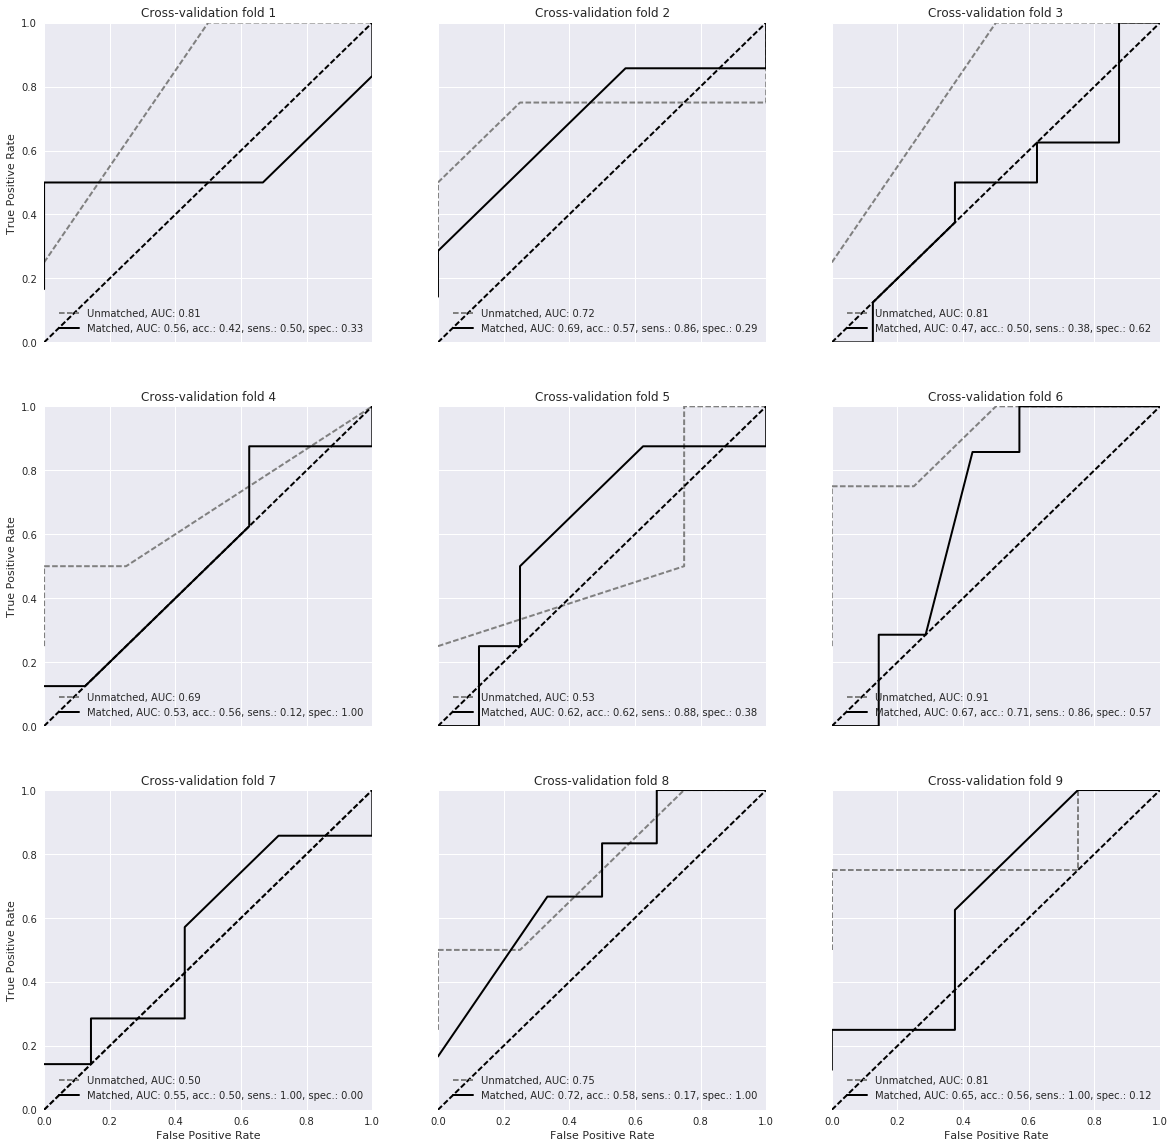

In [22]:
rocfigs

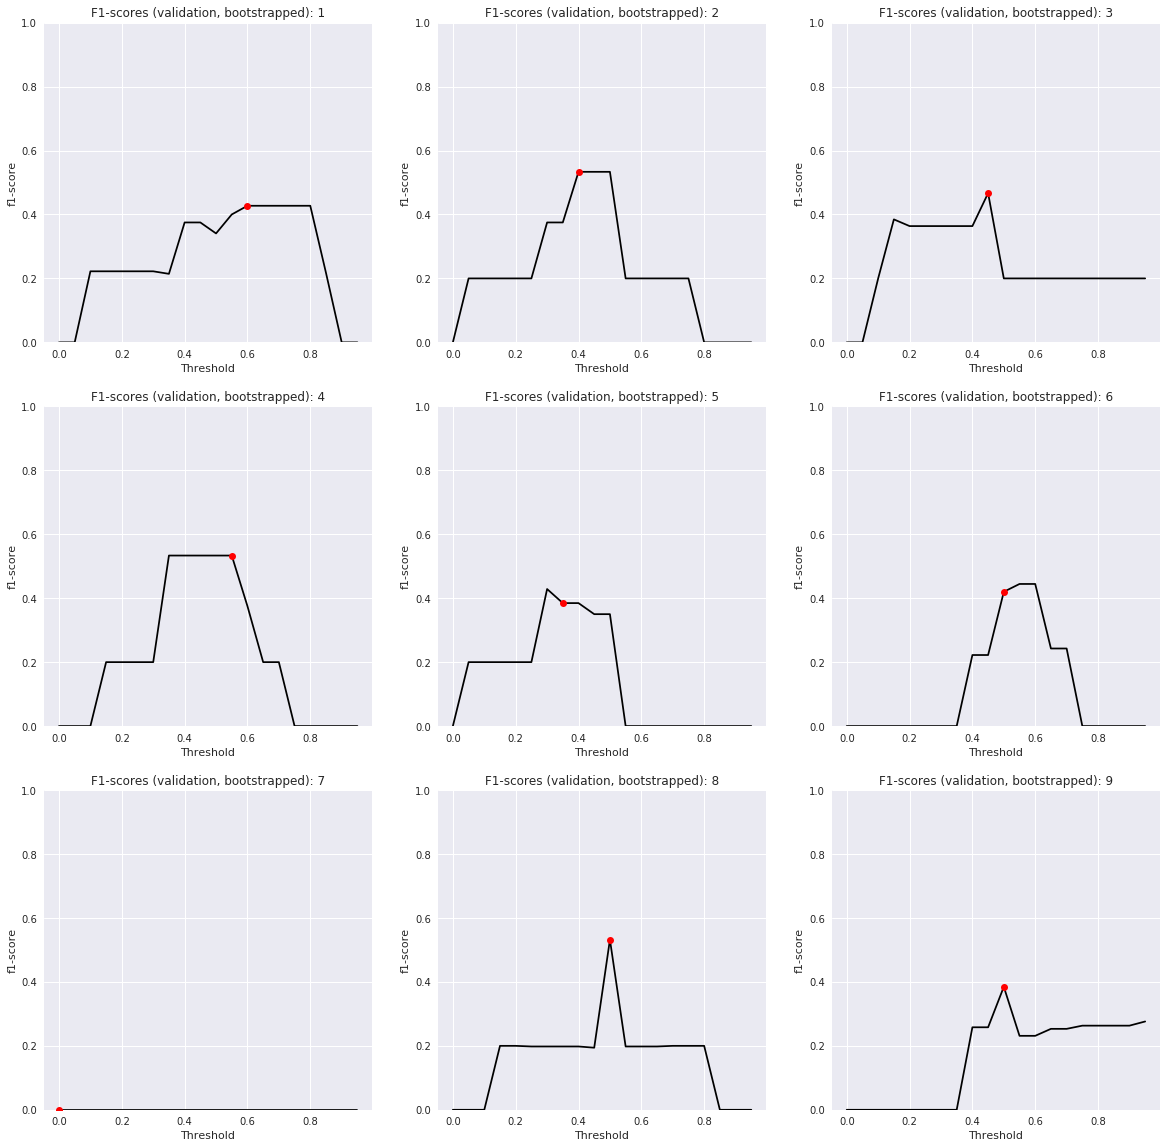

In [23]:
f1figs

In [24]:
n_bootstraps = 1000
test_accuracy_bootstraps_mean = np.ones(n_bootstraps)
test_accuracy_bootstraps_std = np.ones(n_bootstraps)

test_sens_bootstraps_mean = np.ones(n_bootstraps)
test_sens_bootstraps_std = np.ones(n_bootstraps)

test_spec_bootstraps_mean = np.ones(n_bootstraps)
test_spec_bootstraps_std = np.ones(n_bootstraps)
for j in range(n_bootstraps):
    sample = resample(accs_aggr)
    test_accuracy_bootstraps_mean[j] = np.mean(sample)
    test_accuracy_bootstraps_std[j] = np.std(sample)

    sample = resample(senses_aggr)
    test_sens_bootstraps_mean[j] = np.mean(sample)
    test_sens_bootstraps_std[j] = np.std(sample)

    sample = resample(speces_aggr)
    test_spec_bootstraps_mean[j] = np.mean(sample)
    test_spec_bootstraps_std[j] = np.std(sample)

acc_mean = np.mean(test_accuracy_bootstraps_mean)
acc_std = np.mean(test_accuracy_bootstraps_std)
acc_mean_l = np.percentile(test_accuracy_bootstraps_mean, 2.5)
acc_mean_u = np.percentile(test_accuracy_bootstraps_mean, 97.5)
print('Test accuracy: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(acc_mean, acc_mean_l, acc_mean_u, acc_std))

sens_mean = np.mean(test_sens_bootstraps_mean)
sens_std = np.mean(test_sens_bootstraps_std)
sens_mean_l = np.percentile(test_sens_bootstraps_mean, 2.5)
sens_mean_u = np.percentile(test_sens_bootstraps_mean, 97.5)
print('Test sens: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(sens_mean, sens_mean_l, sens_mean_u, sens_std))

spec_mean = np.mean(test_spec_bootstraps_mean)
spec_std = np.mean(test_spec_bootstraps_std)
spec_mean_l = np.percentile(test_spec_bootstraps_mean, 2.5)
spec_mean_u = np.percentile(test_spec_bootstraps_mean, 97.5)
print('Test spec: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(spec_mean, spec_mean_l, spec_mean_u, spec_std))


Test accuracy: 0.56 (CI: [0.511-0.613] +/- 0.0726)
Test sens: 0.635 (CI: [0.413-0.855] +/- 0.309)
Test spec: 0.478 (CI: [0.271-0.726] +/- 0.31)
